#Домашнеее задание: Июльский курс (2020). Pro. Занятие 17
##Алгоритмы кластеризации данных
## Верхошинская Катерина Викторовна

## **LIGHT**






### Задание:

Используйте готовый ноутбук с кластеризацией базы покупок интернет магазина:
1. Удалите из выборки все строки про доставку (автоматически, уже из carts)
2. Выведите две гистограммы
     1. Распределения размеров классов - сколько корзин
     2. Распределение количества уникальных позиций в классе
3. Напишите продвинутую функцию визуализации одного выбранного класса
     1. Размер класса
     2. Количество уникальных позиций
     3. Позиции, которые есть минимум в 20% корзин
     4. Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок

In [ ]:
# Статический вывод графики (графики отображаются в той ячейке, в которой используется plt.show())
%matplotlib inline

import pandas as pd # импортируем библиотеку обработки и анализа данных pandas
import matplotlib.pyplot as plt # Импортируем модуль pyplot библиотеки matplotlib для построения графиков
from tensorflow.keras import utils # Импортируем модуль utils библиотеки tensorflow.keras для получения OHE-представления
import numpy as np # Импортируем библиотеку numpy
from keras.preprocessing.text import Tokenizer, text_to_word_sequence,tokenizer_from_json 

from sklearn.preprocessing import StandardScaler, LabelEncoder # Импортируем библиотеку StandardScaler и LabelEncoder
from sklearn.cluster import KMeans # Импортируем библиотуке KMeans для кластеризации
from sklearn.metrics.cluster import homogeneity_score
from sklearn.manifold import TSNE
import time
import os

from tensorflow.keras.models import Sequential, Model # Полносвязная модель
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Reshape, Conv2DTranspose, Dropout, SpatialDropout1D, BatchNormalization, Embedding, Flatten, Activation # Слои для сети
from tensorflow.keras.preprocessing.sequence import pad_sequences # Метод для работы с последовательностями
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.datasets import mnist

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Базы/online_carts.csv') # Читаем данные из загруженной базы

In [ ]:
df.head()

,Unnamed: 0,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,NaN,Период: Февраль 2019 г. - Август 2019 г.,NaN,NaN,NaN
1,NaN,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),NaN,NaN
2,NaN,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),NaN
3,NaN,Отборы:\nПодразделение В списке (estel.m-cosme...,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Посмотрим на уникальные значения каждого из безымянных столбцов
print(df['Unnamed: 0'].unique(),
      df['Unnamed: 2'].unique(),
      df['Unnamed: 3'].unique(),sep='\n')

[nan]
[nan ' Количество(Базовых ед.)' ' ЗаказПокупателя.ID заказа (Элементы)'
 ... '3472' '7616' '2731']
[nan ' Номенклатура.Наименование (Элементы)' 'Количество' 'Базовых ед.'
 '9' '1' '4' '797' '162' '3' '2' '5' '7' '8' '6' '49' '10' '34' '11' '25'
 '20' '13' '17' '29' '1130' '148' '12' '40' '14' '50' '68' '51' '23' '22'
 '16' '1096' '105' '124' '139' '19' '15' '26' '30' '21' '504' '28' '575'
 '60' '61' '18' '80' '942' '44' '188' '24' '1375' '147' '137' '33' '597'
 '82' '37' '860' '47' '825' '27' '45' '229' '887' '113' '58' '104' '38'
 '1751' '134' '138' '1214' '341' '168' '81' '88' '1074' '150' '32' '52'
 '43' '1023' '64' '72' '31' '39' '1237' '254' '46' '289' '1938' '456'
 '132' '2689' '599' '1771' '181' '322' '77' '556' '90' '256' '42' '57'
 '35' '883' '118' '1078' '145' '2749' '36' '1360' '85' '893' '214' '692'
 '119' '1533' '239' '650' '93' '70' '1551' '158' '78' '102' '780' '291'
 '41' '1278' '140' '48' '161' '1127' '122' '94' '978' '98' '769' '92'
 '159' '720' '69' '56' '1648'

In [ ]:
new = df.drop(['Unnamed: 0'], axis =1)                             # Этот столбец не несет никакой информации, так что выкинем его
new.insert(0, column='Дата', value = [x for x in range(len(new))]) # Вставим новую колонку "Дата", чтобы из базы вытащить временные данные в отдельную колонку
new = new.fillna('unknown')                                        # Все Nan заполним строкой "unknown", чтобы не выскакивало ошибок

In [ ]:
new[new['Валовая прибыль'].str.contains("MCOSM")] # MCOSM - флаг начала корзины

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
10,10,MCOSM13113,26236,9,unknown
22,22,MCOSM13113,1929,4,unknown
166,166,MCOSM4885,350,2,unknown
168,168,MCOSM4996,9436,4,unknown
172,172,MCOSM5963,8625,6,unknown
...,...,...,...,...,...
99589,99589,MCOSM33527,2714,6,unknown
99596,99596,MCOSM33529,3145,9,unknown
99603,99603,MCOSM33530,3030,12,unknown
99616,99616,MCOSM33537,2259,2,unknown


In [ ]:
date_list = list(new[new['Валовая прибыль'].str.contains("\d\d.\d\d.2019")].index) # Здесь будут лежать все индексы строк, где есть информация в формате даты

indx=0
for i in range(len(new)):                       # Проходимся по каждой строке базы
  if i in date_list:                            # Если индекс находится среди тех, где есть формат даты
    indx = i                                    # Обновляем текущий индекс
  new['Дата'][i] = new['Валовая прибыль'][indx] # Присваиваем текущий индекс всем последующим строкам, пока не наткнемся на новый индекс-дату


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
new

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,Период: Февраль 2019 г. - Август 2019 г.,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown
1,Период: Февраль 2019 г. - Август 2019 г.,Показатели: Стоимость продажи (руб.)(С НДС),Количество(Базовых ед.),unknown,unknown
2,Период: Февраль 2019 г. - Август 2019 г.,Группировки строк: ЗаказПокупателя.Дата оправк...,ЗаказПокупателя.ID заказа (Элементы),Номенклатура.Наименование (Элементы),unknown
3,Период: Февраль 2019 г. - Август 2019 г.,Отборы:\nПодразделение В списке (estel.m-cosme...,unknown,unknown,unknown
4,Период: Февраль 2019 г. - Август 2019 г.,unknown,unknown,unknown,unknown
...,...,...,...,...,...
99627,02.09.2019 0:00:00,Kapous Блеск-шампунь Brilliants gloss 250 мл,347,1,unknown
99628,02.09.2019 0:00:00,Крем-бальзам-архитектор волос для восстановле...,345,1,unknown
99629,02.09.2019 0:00:00,Услуга доставки DPD до двери,350,1,unknown
99630,02.09.2019 0:00:00,Шампунь разглаживающий с глиоксиловой кислот...,304,1,unknown


In [ ]:
new = new.drop(new[new['Дата'].str.contains('Период')].index,axis = 0)           # Выкинем превьюшные строки
new = new.drop(new[new['Валовая прибыль'].str.contains('unknown')].index,axis=0) # Выкинем пустые строки между корзинами
new = new.drop(new[new['Валовая прибыль']==new['Дата']].index)                   # Выкинем строки-даты, которые находятся в столбце корзин
new.reset_index(inplace=True)                                                    # Обновим индекс
new = new.drop('index',axis=1)                                                   # Выкинем ненужную, образовавшуюся после предыдущей операции колонку

In [ ]:
cart_list = list(new[new['Валовая прибыль'].str.contains("MCOSM")].index)        # Здесь будут лежать все индексы строк, где строка содержит флаг начала корзины
cafre_list = list(new[new['Валовая прибыль'].str.contains("CAFRE")].index)       # Здесь будут лежать все индексы строк, где строка содержит флаг CAFRE 

Посмотрим на преобразованную базу

In [ ]:
new.head(20)

,Дата,Валовая прибыль,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,01.01.2019 0:00:00,MCOSM13113,26236,9,unknown
1,01.01.2019 0:00:00,CONTURA (HS61) машинка для стрижки волос,9059,1,unknown
2,01.01.2019 0:00:00,Holika Holika Универсальный гель 99% алоэ вера...,539,1,unknown
3,01.01.2019 0:00:00,Kapous Бальзам-уход для придания объема Volume...,181,1,unknown
4,01.01.2019 0:00:00,Kapous Шампунь для придания объема Volume up 3...,181,1,unknown
5,01.01.2019 0:00:00,XPERT (HS71) машинка для стрижки волос,12989,1,unknown
6,01.01.2019 0:00:00,ЛП ТНА САВАЖ ПАНАШ 250 мл,988,1,unknown
7,01.01.2019 0:00:00,перчатки (50 пар) винил размер S черные,319,1,unknown
8,01.01.2019 0:00:00,Услуга доставки DPD до двери,990,1,unknown
9,01.01.2019 0:00:00,Услуга доставки СДЭК,990,1,unknown


In [ ]:
carts = []                     # Здесь будут лежать все корзины 
cart=[]                        # В этом списке будет текущая корзина
i=0                            # Счетчик для прохождения по базе
val = new['Валовая прибыль']   # Будем работать с этим столбцом
allPositions = []              # Создаем пустой список позиций

while i!=len(new):             # Пока не дойдем до конца списка

  if i in cart_list:           # Если счетчик в списке индексов-корзин

    if i!=cart_list[-1]:       # Проверяем, если это не последний индекс-флаг
      ind = cart_list.index(i) # Текущему индексу-флагу присваиваем значение конкретно этой корзины

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен следующему в списке индексу-флагу
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<cart_list[ind+1]-1:
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1 
      
    else:                      # Если же текущий индекс-флаг последний в списке

      # Пробегаемся дальше по счетчику до момента, когда он не будет равен концу списка всех строк в столбце-1
      # Если условия соблюдаются, то закидываем следующую строку в текущую корзину
      # Инкремент счетчика
      while i<(len(new)-1):
        cart.append(val[i+1])
        allPositions.append(val[i+1]) 
        i+=1

    carts.append(cart)         # Закидываем корзину в список всех корзин
    cart=[]                    # Очищаем корзину
    
  else:
    i+=1                       # Если счетчик не в списке корзин, то инкрементируем
 


In [ ]:
len(carts)

13567

In [ ]:
items = 0
for cart in carts:
    for item in cart:
        items += 1
print(items)

85617


In [ ]:
print(len(carts)==len(cart_list))   # Проверка, если у нас количество корзин совпадает с количеством флагов корзин
print('Количество всех позиций: ', len(allPositions)) 
print('Пример того, что лежит в корзине: ', carts[0])

True
Количество всех позиций:  85617
Пример того, что лежит в корзине:  ['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']


In [ ]:
for i in range(10):
    print(carts[i])

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
['OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл', 'OLLIN SERVICE LINE Шампунь.-стабилизатор рН 3.5 1000 мл', 'Масло-уход для светлых волос  ESTEL PRIMA BLONDE 100 мл.', 'Услуга доставки Почта России', '/101 Крем-краска ESTEL PRINCESS ESSEX пепельный', '/44 Крем-краска ESTEL PRINCESS ESSEX медный', '0/00 Стойкая крем-краска чистый тон', '0/00N Крем-краска ESTEL PRINCESS ESSEX нейтральный', '0/11 Крем-краска ESTEL PRINCESS ESSEX синий', '0/22 Крем-краска ESTEL PRINCESS ESSEX зеленый', '0/33 Крем-краска ESTEL PRINCESS ESSEX желтый', '0/33 Стойкая крем-краска интенсивный золотистисты', '0/55 Крем-краска

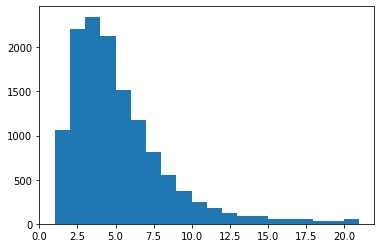

In [ ]:
# Отобразим гистограмму размеров корзин
plt.hist([len(c) for c in carts], 20, [1, 21])
plt.show()

In [ ]:
allPositions[:10]

['CONTURA (HS61) машинка для стрижки волос',
 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл',
 'Kapous Бальзам-уход для придания объема Volume up 350 мл',
 'Kapous Шампунь для придания объема Volume up 350 мл',
 'XPERT (HS71) машинка для стрижки волос',
 'ЛП ТНА САВАЖ ПАНАШ 250 мл',
 'перчатки (50 пар) винил размер S черные',
 'Услуга доставки DPD до двери',
 'Услуга доставки СДЭК',
 'OLLIN SERVICE LINE Увлаж. Бальзам для волос 1000 мл']

In [ ]:
len(allPositions)

85617

In [ ]:
labelEncoder = LabelEncoder()  # Создаем объект LabelEncoder 
labelEncoder.fit(allPositions) # Обрабатываем все имеющиеся позиции товаров

LabelEncoder()

In [ ]:
maxPositionsCount = max(labelEncoder.transform(allPositions))+1 # Посчитаем количество уникальных товаров
print(maxPositionsCount)                                        # Отобразим это количество

6663


In [ ]:
cartsIndexes = [labelEncoder.transform(c) for c in carts] # Создаем список индексов для каждой корзины

In [ ]:
n = 0                  # Укажем номер корзины
print(carts[n])        # Отобразим содержимое этой корзины
print(cartsIndexes[n]) # Отобразим соответствующие индексы

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные', 'Услуга доставки DPD до двери', 'Услуга доставки СДЭК']
[1503 1732 1804 1987 2962 4226 6274 5656 5660]


In [ ]:
'''
  Функция преобразования вектора по приницпу bag of words
    Входные параметры:
      - trainVector - исходный вектор индексов слов
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированный вектор из 0 и 1
'''
def changeXTo01(trainVector, wordsCount):
  out = np.zeros(wordsCount)                   # Создаем вектор из нулей длинной wordsCount
  for x in trainVector:                        # Пробегаем по всем индексам в trainVector
    out[x] = 1                                 # Изменяем на 1 значение out в позиции текущего индекса 
  return out                                   # Возвращаем сформированный вектор


'''
  Функция преобразования выборки (обучающей или проверочной) по принципе Bag of words
    Входные параметры:
      - trainSet - выборка
      - wordsCount - установленная длинна вектора
    Функция возращает: 
      - сформированная выборка из 0 и 1
'''
def changeSetTo01(trainSet, wordsCount):
  out = []                                     # Создаем пустой список  
  for x in trainSet:                           # Пробегаем по всем элемента выборки
    out.append(changeXTo01(x, wordsCount))     # Получаем вектор Bag of words для текущего элемента    
  return np.array(out)                         # Возрващаем сформированную выборку

In [ ]:
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount) # Создаем выборку по принципу bag of words

In [ ]:
n = 5                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['10/65 светлый блондин фиолетово-красный DLSe', '10/76 светлый блондин коричнево-фиолетовый DLSe', 'Бальзам DE LUXE для выравнивания структуры 1000 мл.', 'Бальзам DE LUXE стабилизатор цвета 1000 мл.', 'Восстанавливающий эликсир LuxeOil 100 мл.', 'Разглаживающее масло для интенсивного блеска 100 мл. Wella', 'Шампунь DE LUXE интенсивное очищение 1000 мл.', 'Шампунь DE LUXE стабилизатор цвета 1000 мл.']
[ 211  239 3092 3093 3323 5181 5742 5743]
[0. 0. 0. ... 0. 0. 0.]


In [ ]:
%%time
cur_time = time.time()
clustersCount = 8                                  # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts)                            # Преобразуем список корзин в numpy
print('Время обработки: ', round(time.time() - cur_time,2),'c')

Время обработки:  66.38 c
CPU times: user 1min 17s, sys: 5.45 s, total: 1min 22s
Wall time: 1min 6s


In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
  print(i, s)

[4 0 4 ... 1 1 1]
0 123
1 5527
2 3320
3 130
4 3814
5 75
6 226
7 352


In [ ]:
def getCluster(x):
  clasterSize = x.shape[0]                           # Берем размер кластера
  sumX = np.sum(x, axis=0)                           # Считаем сумму кластера по позициям
  sumX /= clasterSize                                # Смотрим насколько часто конкретная позиция появляется в данном кластере
  
  positions = []                                     # Создаем пустой список позиций
  positionValues = []                                # Создаем пустой список значений
  
  for i in range(sumX.shape[0]):                     # Пробегаем по всем имеющимся примерам товаров
    if (sumX[i] > 0):                                # Если товар присутствует в данном кластере
      position = labelEncoder.inverse_transform([i]) # Получаем обратный энкодер
      positions.append(position)                     # Добавляем позицию в список позиций 
      positionValues.append(sumX[i])                 # В списк значений добавляем количество данной позиции в текущем кластере
  
  return positions, positionValues                   # Возвращаем список позиций кластера и количество каждой позиции

In [ ]:
for clusterNumber in range(len(clusterSize)):                # Пробегаем по всем кластерам
  if (clusterSize[clusterNumber] > 5):                       # Если размер кластера больше 5
    pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
    print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
    print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
    pos = np.array(pos)                                      # Преобразуем в numpy
    posVal = np.array(posVal)                                # Преобразуем в numpy
    indexes = posVal > 0.6                                   # Берем индексы тех позиций, доля которых составляет больше 20%
    indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
    indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

    # Отображаем долю позиции и название самой позиции
    for i in range(len(indexedPos)):
      print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

    print()
    print()

Покупок: 123
Позиций: 3043
73.0% ['Услуга доставки Почта России']
70.0% ['Услуга доставки СДЭК']


Покупок: 5527
Позиций: 5126


Покупок: 3320
Позиций: 3702
100.0% ['Услуга доставки Почта России']


Покупок: 130
Позиций: 849
96.0% ['Деликатный шампунь для окрашенных волос OTIUM COLOR LIFE 1000 мл.']


Покупок: 3814
Позиций: 3346
100.0% ['Услуга доставки СДЭК']


Покупок: 75
Позиций: 1644
76.0% ['Флюид-коктейль ЖИДКИЙ ШЕЛК- 7 масел чемпионов 50 ml']


Покупок: 226
Позиций: 829
100.0% ['Скраб антицеллюлитный (выравнивающий) Likato 250мл']


Покупок: 352
Позиций: 1048
68.0% ['Бальзам для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']
96.0% ['Шампунь для интенсивного увлажнения волос OTIUM AQUA 1000 мл.']




Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
Готово разбиение на 13 классов
Готово разбиение на 14 классов
CPU times: user 16min 10s, sys: 1min 6s, total: 17min 16s
Wall time: 13min 44s


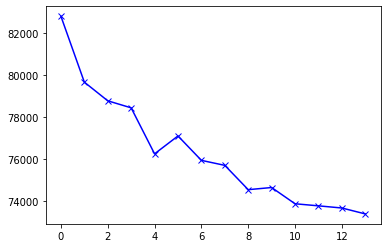

In [ ]:
%%time
cost = []
for i in range(1,15):
  kmean = KMeans(i*1) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i*1, " классов", sep="")
    
plt.plot(cost, 'bx-')

In [ ]:
max(labels)

7

In [ ]:
# Разбиение на 280 классов
for clusterNumber in range(max(labels)):                     # Пробегаем по всем значениям
    if (clusterSize[clusterNumber] > 5):                     # Если размер кластера больше 5
      pos, posVal = getCluster(carts01[labels==clusterNumber]) # Получаем позиции и их количество в текущем кластере
      print("Покупок:", clusterSize[clusterNumber])            # Выводим размер текущего кластера
      print("Позиций:", len(pos))                              # Выводим общее число позиций в текущем кластере
      pos = np.array(pos)                                      # Преобразуем в numpy
      posVal = np.array(posVal)                                # Преобразуем в numpy
      indexes = posVal > 0.2                                   # Берем индексы тех позиций, доля которых составляет больше 20%
      indexedPos = pos[indexes]                                # Выбираем эти позиции из pos
      indexedPosVal = posVal[indexes]                          # Выбираем доли этих позиций

      # Отображаем долю позиции и название самой позиции
      for i in range(len(indexedPos)):
        print(round(100*indexedPosVal[i]), "% ", indexedPos[i], sep="")

      print()
      print()

Покупок: 123
Позиций: 3043
24.0% ['10/81 яркий блонд перламутрово-пепельный Интенсивное тонирование НОВЫЙ']
29.0% ['12/0 Стойкая крем-краска специальный блонд']
39.0% ['12/61 Стойкая крем-краска специальный блонд фиолет']
28.0% ['12/81 Стойкая крем-краска специальный блонд жемч']
33.0% ['12/89 Стойкая крем-краска специальный блонд жемчуж']
28.0% ['4/0 Стойкая крем-краска шатен']
34.0% ['5/0 Стойкая крем-краска светлый шатен']
20.0% ['5/71 Стойкая крем-краска светлый шатен коричнево-п']
32.0% ['6/0 Стойкая крем-краска темный блонд']
24.0% ['6/1 Стойкая крем-краска темный блонд пепельный']
28.0% ['6/7 Стойкая крем-краска темный блонд коричневый']
27.0% ['6/71 Стойкая крем-краска темный блонд коричнево-пе']
24.0% ['6/77 Стойкая крем-краска темный блонд интенсивно-коричневый']
41.0% ['7/0 Стойкая крем-краска блонд']
21.0% ['7/71 Стойкая крем-краска блонд коричнево-пепельный']
24.0% ['8/0 Стойкая крем-краска светлый блонд']
20.0% ['8/38 Стойкая крем-краска светлый блонд золотисто-жемчужный'

### 1. Удалите из выборки все строки про доставку (автоматически, уже из carts)



In [ ]:
carts_ = [[item for item in cart if not item.startswith('Услуга доставки')] for cart in carts]
len(carts_) # новый список содержит корзины, из которых удалены доставки

13567

In [ ]:
# Число позиций после удаления доставок:
items = 0
for cart in carts_:
    for item in cart:
        items += 1
print(items)

76716


In [ ]:
# Пересоздадим списки cartsIndexes И carts01:
carts, carts_ = carts_, carts # теперь в carts_ будут корзины с доставками
cartsIndexes = [labelEncoder.transform(c) for c in carts] 
carts01 = changeSetTo01(cartsIndexes, maxPositionsCount)

**Проверим, что удаление удалось**

In [ ]:
n = 0                  # Указываем номер корзины
print(carts[n])        # Выводим содержимое корзины
print(cartsIndexes[n]) # Выводим список соответствующих индексов
print(carts01[n])      # Выводим соответсвующий список bag of words

['CONTURA (HS61) машинка для стрижки волос', 'Holika Holika Универсальный гель 99% алоэ вера, 250 мл', 'Kapous Бальзам-уход для придания объема Volume up 350 мл', 'Kapous Шампунь для придания объема Volume up 350 мл', 'XPERT (HS71) машинка для стрижки волос', 'ЛП ТНА САВАЖ ПАНАШ 250 мл', 'перчатки (50 пар) винил размер S черные']
[1503 1732 1804 1987 2962 4226 6274]
[0. 0. 0. ... 0. 0. 0.]


### 2. Выведите две гистограммы

     1. Распределения размеров классов - сколько корзин
     2. Распределение количества уникальных позиций в классе



Готово разбиение на 1 классов
Готово разбиение на 2 классов
Готово разбиение на 3 классов
Готово разбиение на 4 классов
Готово разбиение на 5 классов
Готово разбиение на 6 классов
Готово разбиение на 7 классов
Готово разбиение на 8 классов
Готово разбиение на 9 классов
Готово разбиение на 10 классов
Готово разбиение на 11 классов
Готово разбиение на 12 классов
CPU times: user 11min 41s, sys: 50.2 s, total: 12min 31s
Wall time: 9min 55s


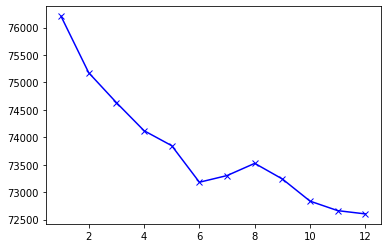

In [ ]:
%%time
cost = []
for i in range(1, 13):
  kmean = KMeans(i) # *20
  kmean.fit(carts01)
  cost.append(kmean.inertia_)
  print("Готово разбиение на ", i, " классов", sep="")
    
plt.plot(list(range(1, 13)), cost, 'bx-')


In [ ]:
%%time
clustersCount = 7                                   # Указываем количество кластеров
kmean = KMeans(clustersCount)                        # Создаем объект KMeans
kmean.fit(carts01)                                   # Производим кластеризацию набора carts01
labels = kmean.labels_                               # Сохраняем метки в переменную labels

npCarts = np.array(carts) 

CPU times: user 1min 18s, sys: 4.29 s, total: 1min 22s
Wall time: 1min 9s


In [ ]:
len(carts), len(carts01)

(13567, 13567)

In [ ]:
print(labels)                                                   # Отображаем метки кластеров
clusterSize = [sum(labels==i) for i in range(0, clustersCount)] # Создадим список размеров каждого кластера

# Выведем номер кластера и его размер
for i, s in enumerate(clusterSize):
    print(i, s)

[4 5 4 ... 4 4 4]
0 102
1 371
2 1
3 267
4 12148
5 110
6 568





1. Гистограмма распределения размеров классов - сколько корзин

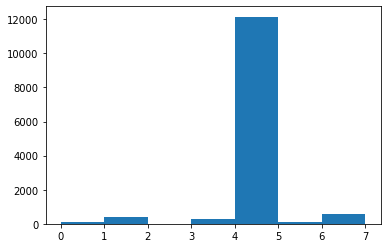

In [ ]:
_ = plt.hist(labels, clustersCount, [0, clustersCount])



2. Гистограмма распределения  количества уникальных позиций в классе


In [ ]:
# возьмем самый большой класс
n = 2 # номер класса
cluster = [cartsIndexes[i] for i in range(len(carts)) if labels[i] == n]
items = []
for i in cluster:
    items.extend(i)

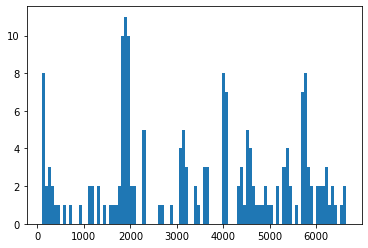

In [ ]:
_ = plt.hist(items, 100)

### 3. Напишите продвинутую функцию визуализации одного выбранного класса
     1. Размер класса
     2. Количество уникальных позиций
     3. Позиции, которые есть минимум в 20% корзин
     4. Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок


1. Размер класса

In [ ]:
# функция для вывода размера класса
def printSize(cluster):
    """
    cluster: список корзин (в любом формате) 
    """
    print("Cluster has %d carts" % len(cluster))

In [ ]:
n = 2 # номер класса
cluster = [cartsIndexes[i] for i in range(len(carts)) if labels[i] == n]
items = []
for i in cluster:
    items.extend(i)
print("Cluster #%d has %d carts" % (n , len(cluster)))

Cluster #2 has 1 carts


2. Количество уникальных позиций

In [ ]:
# функция выводящая количество уникальных позиций
def printNumberUniqPositions(cluster):
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    print("Uniq positions:", len(uniqs))

In [ ]:
printNumberUniqPositions(cluster)

Uniq positions: 181


3. Позиции, которые есть минимум в 20% корзин

In [ ]:
def printPopularPositions(cluster, level=0.2):
    N = int(level*len(cluster)) 
    items = []
    for cart in cluster:
        items.extend(cart)
    uniqs = set()
    [uniqs.add(item) for item in items]
    qty = {id: 0 for id in uniqs} # словарь id -> в скольких корзинах встречается позиция id
    for cart in cluster:
        for id in cart:
            qty[id] += 1
    ids20 = [id for id in uniqs if qty[id] > N] # список ids которые встретились более чем в N корзинах
    print('Позиции, которые есть минимум в %d%% корзин:' % int(100*level), ids20)

In [ ]:
printPopularPositions(cluster, level=0.2)

Позиции, которые есть минимум в 20% корзин: [6656, 3585, 3586, 3587, 4612, 3077, 4614, 6162, 2071, 3097, 3104, 3106, 5156, 2086, 2601, 5675, 5676, 1581, 5677, 6193, 3134, 5182, 3136, 4673, 3139, 6211, 5700, 3148, 4685, 590, 6226, 3669, 3671, 5721, 5722, 6236, 3165, 5726, 98, 3682, 100, 103, 104, 1128, 1129, 107, 108, 109, 117, 3190, 5752, 3194, 6267, 5756, 5755, 2687, 1664, 5766, 4746, 5770, 3221, 5785, 1180, 5792, 4769, 1188, 5288, 5290, 5291, 179, 5821, 5825, 1732, 5828, 4298, 6350, 213, 6357, 4318, 747, 1776, 4849, 5362, 1791, 2305, 2307, 2309, 2310, 1804, 1807, 2319, 5391, 4370, 5395, 278, 5910, 5403, 1820, 5915, 287, 1823, 1824, 290, 1827, 1830, 1831, 4903, 2861, 4910, 1841, 1331, 6451, 5429, 1338, 4415, 1864, 3406, 1880, 3416, 1882, 1885, 5470, 1887, 351, 352, 1894, 4461, 6001, 1910, 1911, 1912, 1913, 4983, 3968, 1411, 6534, 3977, 1932, 1934, 1935, 914, 1941, 3989, 4501, 409, 1945, 3487, 1954, 4003, 1956, 4005, 4515, 4520, 5546, 1963, 5036, 1966, 6064, 4017, 1973, 4025, 4026, 454

In [ ]:
printPopularPositions(cluster, level=0.02)

Позиции, которые есть минимум в 2% корзин: [6656, 3585, 3586, 3587, 4612, 3077, 4614, 6162, 2071, 3097, 3104, 3106, 5156, 2086, 2601, 5675, 5676, 1581, 5677, 6193, 3134, 5182, 3136, 4673, 3139, 6211, 5700, 3148, 4685, 590, 6226, 3669, 3671, 5721, 5722, 6236, 3165, 5726, 98, 3682, 100, 103, 104, 1128, 1129, 107, 108, 109, 117, 3190, 5752, 3194, 6267, 5756, 5755, 2687, 1664, 5766, 4746, 5770, 3221, 5785, 1180, 5792, 4769, 1188, 5288, 5290, 5291, 179, 5821, 5825, 1732, 5828, 4298, 6350, 213, 6357, 4318, 747, 1776, 4849, 5362, 1791, 2305, 2307, 2309, 2310, 1804, 1807, 2319, 5391, 4370, 5395, 278, 5910, 5403, 1820, 5915, 287, 1823, 1824, 290, 1827, 1830, 1831, 4903, 2861, 4910, 1841, 1331, 6451, 5429, 1338, 4415, 1864, 3406, 1880, 3416, 1882, 1885, 5470, 1887, 351, 352, 1894, 4461, 6001, 1910, 1911, 1912, 1913, 4983, 3968, 1411, 6534, 3977, 1932, 1934, 1935, 914, 1941, 3989, 4501, 409, 1945, 3487, 1954, 4003, 1956, 4005, 4515, 4520, 5546, 1963, 5036, 1966, 6064, 4017, 1973, 4025, 4026, 4540

In [ ]:
printPopularPositions(cluster, level=0.01)

Позиции, которые есть минимум в 1% корзин: [6656, 3585, 3586, 3587, 4612, 3077, 4614, 6162, 2071, 3097, 3104, 3106, 5156, 2086, 2601, 5675, 5676, 1581, 5677, 6193, 3134, 5182, 3136, 4673, 3139, 6211, 5700, 3148, 4685, 590, 6226, 3669, 3671, 5721, 5722, 6236, 3165, 5726, 98, 3682, 100, 103, 104, 1128, 1129, 107, 108, 109, 117, 3190, 5752, 3194, 6267, 5756, 5755, 2687, 1664, 5766, 4746, 5770, 3221, 5785, 1180, 5792, 4769, 1188, 5288, 5290, 5291, 179, 5821, 5825, 1732, 5828, 4298, 6350, 213, 6357, 4318, 747, 1776, 4849, 5362, 1791, 2305, 2307, 2309, 2310, 1804, 1807, 2319, 5391, 4370, 5395, 278, 5910, 5403, 1820, 5915, 287, 1823, 1824, 290, 1827, 1830, 1831, 4903, 2861, 4910, 1841, 1331, 6451, 5429, 1338, 4415, 1864, 3406, 1880, 3416, 1882, 1885, 5470, 1887, 351, 352, 1894, 4461, 6001, 1910, 1911, 1912, 1913, 4983, 3968, 1411, 6534, 3977, 1932, 1934, 1935, 914, 1941, 3989, 4501, 409, 1945, 3487, 1954, 4003, 1956, 4005, 4515, 4520, 5546, 1963, 5036, 1966, 6064, 4017, 1973, 4025, 4026, 4540

4. Уникальные слова в описаниях позиций, которые встречаются минимум в 20% позиций, для отслеживания моно-брендовых и моно-товарных закупок

In [ ]:
maxWordsCount = 10000
tok = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./:;<=>?@[\\]^_`{|}~\t\n\xa0', lower=True, split=' ', oov_token='unknown', char_level=False)
positions = []
for p in carts:
    positions.extend(p)
tok.fit_on_texts(positions)         
items = list(tok.word_index.items())

In [ ]:
items[:10]

[('unknown', 1),
 ('мл', 2),
 ('для', 3),
 ('волос', 4),
 ('крем', 5),
 ('шампунь', 6),
 ('1000', 7),
 ('краска', 8),
 ('с', 9),
 ('estel', 10)]

In [ ]:
len(items)

5888

In [ ]:
positionIds = tok.texts_to_sequences(positions) 
positionIds[:10]

[[4290, 4291, 967, 3, 729, 4],
 [337, 337, 763, 122, 1313, 326, 1057, 14, 2],
 [15, 17, 112, 3, 204, 95, 196, 430, 270, 2],
 [15, 6, 3, 204, 95, 196, 430, 270, 2],
 [3588, 3589, 967, 3, 729, 4],
 [364, 1288, 3360, 3361, 14, 2],
 [420, 74, 478, 575, 458, 515, 587],
 [18, 170, 125, 557, 17, 3, 4, 7, 2],
 [18, 170, 125, 6, 242, 657, 53, 37, 7, 2],
 [71, 112, 3, 120, 4, 10, 107, 98, 16, 2]]

In [ ]:
uniqPositions = set()
[uniqPositions.add(p) for p in positions]
print("Distinct positions:", len(uniqPositions))

Distinct positions: 6658


In [ ]:
def printPopularWords(cluster, level=0.2):
    pos_count = 0
    for cart in cluster:
        pos_count += len(cart) # Находим полное число позиций в кластере
    N = int(level*pos_count) # Пороговое количество позиций для слова.
    qty = {id: 0 for id in range(1, len(tok.word_index.items())+1)} # словарь id -> в скольких позициях встречается слово id
    for item in positionIds:
        for id in item:
            qty[id] += 1
    ids20 = [id for id in range(1, len(tok.word_index.items())+1) if qty[id] > N] # список ids слов, которые встретились более чем в N позициях
    words = [tok.index_word[id] for id in ids20]
    print('слова, которые есть минимум в %d%% позиций:' % int(100*level), words)

In [ ]:
printPopularWords(cluster, level=0.2)

слова, которые есть минимум в 20% позиций: ['мл', 'для', 'волос', 'крем', 'шампунь', '1000', 'краска', 'с', 'estel', 'маска', 'блонд', 'и', '250', 'kapous', '100', 'бальзам', 'ollin', '200', 'londa', 'color', '1', 'светлый', 'princess', 'essex', '6', 'блондин', 'стойкая', '0', '9', '7', '300', '500', 'пепельный', '10', 'русый', '5', 'спрей', 'otium', 'dewal', '60', '8', 'окрашенных', 'likato', 'фиолетовый', 'кондиционер', 'в', 'de', 'luxe', 'эмульсия', 'коричневый', 'studio', '3', '4', 'серии', 'гр', 'коричнево', 'шатен', 'keratin', 'оксигент', 'оттенков', '250мл', 'маслом', '12', 'фиксации', 'matrix', '150', 'classic', 'л', 'dl', 'масло', 'см', 'д', '50', 'ml', 'curex', 'интенсивного', 'светло', '2', 'пудра', 'окислительная', 'шт', '60мл', 'сыворотка', 'professional', 'oil', 'оттенок', 'темный', 'увлажнения', 'перманентная', 'очень', 'холодных', 'всех', '«kapous»', 'объема', 'мм', 'aqua', 'blonde', 'поврежденных', 'кератин', 'применения', 'серебристый', '750', 'типов', 'ежедневного', 

**Искомая продвинутая функция**

In [ ]:
def printAdvanced(cluster):
    printSize(cluster)
    printNumberUniqPositions(cluster)
    printPopularPositions(cluster)
    printPopularWords(cluster)

In [ ]:
printAdvanced(cluster)

Cluster has 1 carts
Uniq positions: 181
Позиции, которые есть минимум в 20% корзин: [6656, 3585, 3586, 3587, 4612, 3077, 4614, 6162, 2071, 3097, 3104, 3106, 5156, 2086, 2601, 5675, 5676, 1581, 5677, 6193, 3134, 5182, 3136, 4673, 3139, 6211, 5700, 3148, 4685, 590, 6226, 3669, 3671, 5721, 5722, 6236, 3165, 5726, 98, 3682, 100, 103, 104, 1128, 1129, 107, 108, 109, 117, 3190, 5752, 3194, 6267, 5756, 5755, 2687, 1664, 5766, 4746, 5770, 3221, 5785, 1180, 5792, 4769, 1188, 5288, 5290, 5291, 179, 5821, 5825, 1732, 5828, 4298, 6350, 213, 6357, 4318, 747, 1776, 4849, 5362, 1791, 2305, 2307, 2309, 2310, 1804, 1807, 2319, 5391, 4370, 5395, 278, 5910, 5403, 1820, 5915, 287, 1823, 1824, 290, 1827, 1830, 1831, 4903, 2861, 4910, 1841, 1331, 6451, 5429, 1338, 4415, 1864, 3406, 1880, 3416, 1882, 1885, 5470, 1887, 351, 352, 1894, 4461, 6001, 1910, 1911, 1912, 1913, 4983, 3968, 1411, 6534, 3977, 1932, 1934, 1935, 914, 1941, 3989, 4501, 409, 1945, 3487, 1954, 4003, 1956, 4005, 4515, 4520, 5546, 1963, 5036,

## **PRO** 




### **Вариант 1**

Задание по кластеризации слов в Embedding пространстве
1. Возьмите любую текстовую базу (например, базу книг писателей из наших  прошлых занятий)
2. Сделайте классификатор с embedding слоем в начале (не Bag of words)
3. Обучите классификатор
4. Возьмите предобученный embedding слой и перегоните все слова из полного словаря в embedding пространство
5. Запустите кластеризацию
6. Выведите устойчивые классы слов
7. Проведите для разного числа классов и разной размерности embedding пространства
8. Напишите выводы

#### 1. Возьмите любую текстовую базу (например, базу книг писателей из наших  прошлых занятий)


In [ ]:
# Загружаем базу писателей
# Указываем путь к базе в Google Drive, создаем папку texts и извлекаем туда базу
!unzip -q '/content/drive/My Drive/Colab Notebooks/Базы/Тексты писателей.zip' -d /content/texts 

In [ ]:
def readText(fileName): # Объявляем функции для чтения файла. На вход отправляем путь к файлу
  f = open(fileName, 'r')        # Задаем открытие нужного файла в режиме чтения
  text = f.read()                # Читаем текст
  text = text.replace("\n", " ") # Переносы строки переводим в пробелы
  
  return text                    # Возвращаем текст файла

className = ["О. Генри", "Стругацкие", "Булгаков", "Саймак", "Фрай", "Брэдберри"] # Объявляем интересующие нас классы
nClasses = len(className) # Считаем количество классов

# Формирование обучающей выборки по листу индексов слов
# (разделение на короткие векторы)
def getSetFromIndexes(wordIndexes, xLen, step): # функция принимает последовательность индексов, размер окна, шаг окна
  xSample = [] # Объявляем переменную для векторов
  wordsLen = len(wordIndexes) # Считаем количество слов
  index = 0 # Задаем начальный индекс 

  while (index + xLen <= wordsLen):# Идём по всей длине вектора индексов
    xSample.append(wordIndexes[index:index+xLen]) # "Откусываем" векторы длины xLen
    index += step # Смещаеммся вперёд на step
    
  return xSample
  
# Формирование обучающей и проверочной выборки
# Из двух листов индексов от двух классов
def createSetsMultiClasses(wordIndexes, xLen, step): # Функция принимает последовательность индексов, размер окна, шаг окна

  # Для каждого из 6 классов
  # Создаём обучающую/проверочную выборку из индексов
  nClasses = len(wordIndexes) # Задаем количество классов выборки
  classesXSamples = []        # Здесь будет список размером "кол-во классов*кол-во окон в тексте*длину окна (например, 6 по 1341*1000)"
  for wI in wordIndexes:      # Для каждого текста выборки из последовательности индексов
    classesXSamples.append(getSetFromIndexes(wI, xLen, step)) # Добавляем в список очередной текст индексов, разбитый на "кол-во окон*длину окна" 

  # Формируем один общий xSamples
  xSamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*длину окна (например, 15779*1000)"
  ySamples = [] # Здесь будет список размером "суммарное кол-во окон во всех текстах*вектор длиной 6"
  
  for t in range(nClasses): # В диапазоне кол-ва классов(6)
    xT = classesXSamples[t] # Берем очередной текст вида "кол-во окон в тексте*длину окна"(например, 1341*1000)
    for i in range(len(xT)): # И каждое его окно
      xSamples.append(xT[i]) # Добавляем в общий список выборки
      ySamples.append(utils.to_categorical(t, nClasses)) # Добавляем соответствующий вектор класса

  xSamples = np.array(xSamples) # Переводим в массив numpy для подачи в нейронку
  ySamples = np.array(ySamples) # Переводим в массив numpy для подачи в нейронку

  
  return (xSamples, ySamples) #Функция возвращает выборку и соответствующие векторы классов


In [ ]:
# Класс строит график всего обучения, состоявшего из нескольких этапов.
class LearnHistory:
    def __init__(self):
        self.history = {'loss':[], 'val_loss': []}

    def append(self, history):
        self.history['loss'].extend(history.history['loss'])
        self.history['val_loss'].extend(history.history['val_loss'])

    def plot(self, ylim=None):
        ep = [i+1 for i in range(len(self.history['loss']))]
        plt.plot(ep, self.history['loss'], label='MSE на обучающем наборе')
        plt.plot(ep, self.history['val_loss'], label='MSE на проверочном наборе')
        plt.ylabel('Средняя ошибка')
        plt.xlabel('Эпоха')
        if ylim is not None:
            plt.ylim(0, ylim)
        plt.title('История обучения')
        plt.grid()
        plt.legend()
        plt.show()

In [ ]:
trainText = [] #Формируем обучающие тексты
testText = [] #Формируем тестовые тексты

#Формирование необходимо произвести следующим образом 
#Класс каждого i-ого эллемента в обучающей выборке должен соответствовать 
#классу каждого i-ого эллемента в тестовой выборке

for i in className: #Проходим по каждому классу
  for j in os.listdir('texts/'): #Проходим по каждому файлу в папке с текстами #
    if i in j: #Проверяем, содержит ли файл j в названии имя класса i
      
      if 'Обучающая' in j: #Если в имени найденного класса есть строка "Обучающая" 
        trainText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в обучающую выборку') #Выводим информацию
      if 'Тестовая' in j: #Если в имени найденного класса есть строка "Тестовая"
        testText.append(readText('texts/' + j)) #добавляем в обучающую выборку
        print(j, 'добавлен в тестовую выборку') #Выводим информацию
  print()

(О. Генри) Тестовая_20 вместе.txt добавлен в тестовую выборку
(О. Генри) Обучающая_50 вместе.txt добавлен в обучающую выборку

(Стругацкие) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Стругацкие) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Булгаков) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Булгаков) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Клиффорд_Саймак) Тестовая_2 вместе.txt добавлен в тестовую выборку
(Клиффорд_Саймак) Обучающая_5 вместе.txt добавлен в обучающую выборку

(Макс Фрай) Обучающая_5 вместе.txt добавлен в обучающую выборку
(Макс Фрай) Тестовая_2 вместе.txt добавлен в тестовую выборку

(Рэй Брэдберри) Обучающая_22 вместе.txt добавлен в обучающую выборку
(Рэй Брэдберри) Тестовая_8 вместе.txt добавлен в тестовую выборку



In [ ]:
# Задаём базовые параметры
xLen = 1000  # Длина отрезка текста, по которой анализируем, в словах
step = 100  # Шаг разбиения исходного текста на обучающие векторы
maxWordsCount = 50000
tokenizer = Tokenizer(num_words=maxWordsCount, filters='!"#$%&()*+,-–—./…:;<=>?@[\\]^_`{|}~«»\t\n\xa0\ufeff', lower=True, split=' ', oov_token='unknown', char_level=False)
tokenizer.fit_on_texts(trainText)
# Преобразовываем текст в последовательность индексов согласно частотному словарю
trainWordIndexes = tokenizer.texts_to_sequences(trainText) # Обучающие тесты в индексы
testWordIndexes = tokenizer.texts_to_sequences(testText)  # Проверочные тесты в индексы
# Формируем обучающую и тестовую выборку
xTrain, yTrain = createSetsMultiClasses(trainWordIndexes, xLen, step)  # извлекаем обучающую выборку
xTest, yTest = createSetsMultiClasses(testWordIndexes, xLen, step)    # извлекаем тестовую выборку

In [ ]:
xTrain.shape, yTrain.shape, xTest.shape, yTest.shape

((17640, 1000), (17640, 6), (6686, 1000), (6686, 6))

#### 2. Сделайте классификатор с embedding слоем в начале

In [ ]:
def createEmbeddingModel(dim=128, xLen=1000, neurons=1024, activation='softmax'):
    inp = Input(shape=(xLen))
    emb = Embedding(maxWordsCount, dim, input_length=xLen)(inp)
    x = SpatialDropout1D(0.2)(emb)
    x = Flatten()(x)
    x = BatchNormalization()(x)
    x = Dense(neurons, activation="relu")(x)
    x = Dropout(0.2)(x)
    x = BatchNormalization()(x)
    out = Dense(6, activation='softmax')(x)

    model = Model(inp, out)
    embed = Model(inp, emb)

    model.compile(optimizer='adam', 
                loss='categorical_crossentropy', 
                metrics=['accuracy'])
    return model, embed

#### 3. Обучите классификатор

In [ ]:
lh = LearnHistory()
model, embed = createEmbeddingModel()

Epoch 1/10
138/138 [==============================] - 22s 157ms/step - loss: 0.9056 - accuracy: 0.8256 - val_loss: 3.2076 - val_accuracy: 0.1611
Epoch 2/10
138/138 [==============================] - 21s 155ms/step - loss: 0.0074 - accuracy: 0.9997 - val_loss: 1.4733 - val_accuracy: 0.4753
Epoch 3/10
138/138 [==============================] - 22s 156ms/step - loss: 0.0025 - accuracy: 0.9999 - val_loss: 1.3969 - val_accuracy: 0.4783
Epoch 4/10
138/138 [==============================] - 21s 156ms/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 1.3137 - val_accuracy: 0.5387
Epoch 5/10
138/138 [==============================] - 22s 156ms/step - loss: 7.4373e-04 - accuracy: 1.0000 - val_loss: 1.3280 - val_accuracy: 0.5672
Epoch 6/10
138/138 [==============================] - 21s 155ms/step - loss: 4.7771e-04 - accuracy: 1.0000 - val_loss: 1.3667 - val_accuracy: 0.5793
Epoch 7/10
138/138 [==============================] - 21s 155ms/step - loss: 4.8356e-04 - accuracy: 0.9999 - val_loss: 1.4

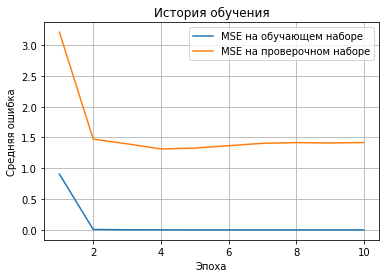

In [ ]:
history = model.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(xTest, yTest))
lh.append(history)
lh.plot()

#### 4. Возьмите предобученный embedding слой и перегоните все слова из полного словаря в embedding пространство


In [ ]:
# преобразуем словарь в двумерный массив
ids = np.array([i for i in range(maxWordsCount)]).reshape(-1, xLen)
ids.shape

(50, 1000)

In [ ]:
# делаем предикт
dim = 128
zTrain = embed.predict(ids)
zTrain = zTrain.reshape(-1, dim)
zTrain.shape

(50000, 128)

В результате получилось 50000 векторов размерности 128

#### 5. Запустите кластеризацию

Попробуем кластеризовать слова по писателям. 

In [ ]:
km = KMeans(6)
km.fit(zTrain)

pred = km.predict(zTrain)

In [ ]:
pred[:20]

array([1, 1, 5, 0, 3, 4, 3, 1, 4, 5, 5, 2, 3, 1, 3, 3, 0, 3, 1, 0],
      dtype=int32)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


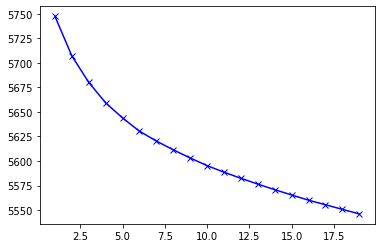

CPU times: user 15min 6s, sys: 1min 16s, total: 16min 23s
Wall time: 14min 51s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain)   # Проводим кластеризацию zTrain
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()
  
# inertia_ - это среднее растояние от точек до центров их классов
# Может использоваться для подбора оптимального количества классов 

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()

#### 6. Выведите устойчивые классы слов

In [ ]:
km = KMeans(200)
km.fit(zTrain)

pred = km.predict(zTrain)

In [ ]:
pred[:10]

array([175, 109, 182, 150,  80,  59, 168,  41, 115,  69], dtype=int32)

In [ ]:
voc = [i for i in range(50000)]
voc[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [ ]:

for i in range(10): # Посмотрим на первые 10 (из 200) кластеров.
    cnt = 0
    print("cluster #%d"%i, end=": ")
    for j in range(50000):
        if pred[j] == i:
            print(tokenizer.index_word[j], end=" ")
            cnt += 1
            if cnt == 20:
                print()
                break


cluster #0: речь минуты странное ушли надеялся точки замер автомобиль чувствуя картер добрался последняя тяжелые рту стеной войне рухнул ситуацию бить морда 
cluster #1: даже вдруг люди понимаю которых ту язык смотрела муж захотелось буквально ненавижу будущем пятна глядели плакать пандарей шума шумно целые 
cluster #2: знаю руки следовало некоторых правило роман вернусь четверть сцену дно умеют дважды села брось помахал трубке описать скрип работой знакомое 
cluster #3: история пришла отчего иш поставить человеческой налил упрямо увидели фабиан спокойствие расскажи поиски ого мостовую часовой деятельности имейте шестой упали 
cluster #4: к бы посмотреть играть театр слышно коралио миру пахло д сволочь бормотал керни поехал вторая царь нога уходит 15 сумасшедший 
cluster #5: одна десять поднял никого вопросы битти пускай хорошее понадобится столовой высокий кости амобилера пола белыми безусловно спрашивать крыльце удалился нажал 
cluster #6: всякого войны трудом честное гостей твоим шк

#### 7. Проведите для разного числа классов и разной размерности embedding пространства


Поскольку на размерности embedding пространства = 128 облако не кластеризовалось, попробуем увеличить размерность пространства в 2 раза.

Epoch 1/10
138/138 [==============================] - 43s 311ms/step - loss: 0.8755 - accuracy: 0.8414 - val_loss: 3.2298 - val_accuracy: 0.1968
Epoch 2/10
138/138 [==============================] - 42s 307ms/step - loss: 0.0081 - accuracy: 0.9997 - val_loss: 1.4968 - val_accuracy: 0.3925
Epoch 3/10
138/138 [==============================] - 42s 308ms/step - loss: 0.0022 - accuracy: 1.0000 - val_loss: 1.3098 - val_accuracy: 0.4566
Epoch 4/10
138/138 [==============================] - 43s 309ms/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 1.1798 - val_accuracy: 0.5357
Epoch 5/10
138/138 [==============================] - 43s 310ms/step - loss: 7.3506e-04 - accuracy: 1.0000 - val_loss: 1.1907 - val_accuracy: 0.5703
Epoch 6/10
138/138 [==============================] - 42s 306ms/step - loss: 4.6826e-04 - accuracy: 1.0000 - val_loss: 1.2392 - val_accuracy: 0.5803
Epoch 7/10
138/138 [==============================] - 43s 308ms/step - loss: 3.5839e-04 - accuracy: 1.0000 - val_loss: 1.2

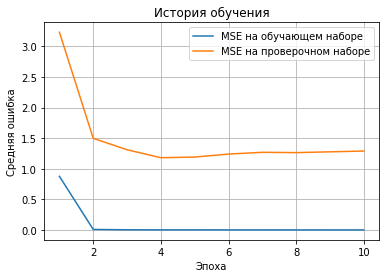

In [ ]:
dim = 256
lh = LearnHistory()
model2, embed2 = createEmbeddingModel(dim=dim)
history = model2.fit(xTrain, 
                    yTrain, 
                    epochs=10,
                    batch_size=128,
                    verbose=1,
                    validation_data=(xTest, yTest))
lh.append(history)
lh.plot()

In [ ]:
zTrain2 = embed2.predict(ids)
zTrain2 = zTrain2.reshape(-1, dim)
zTrain2.shape

(50000, 256)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 


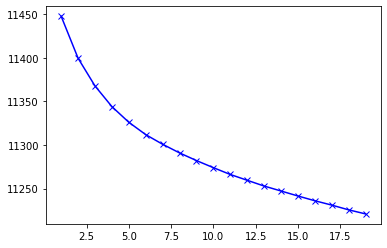

CPU times: user 28min 15s, sys: 2min 14s, total: 30min 29s
Wall time: 27min 50s


In [ ]:
%%time
n_clusters = 20               # Зададим количество кластеров
cost = []                     # Создаем пустой список
for i in range(1, n_clusters): # Пробегаем по списку от 1 до n_clusters
    kmean = KMeans(i)           # Создаем объект KMeans с i-классами
    kmean.fit(zTrain2)   # Проводим кластеризацию zTrain2
    cost.append(kmean.inertia_) # Добавляем в cost элемент kmean.inertia_
    print(i, end=' ')
print()

# Отобразим значения списка cost на графике
plt.plot([i for i in range(1, n_clusters)], cost, 'bx-')
plt.show()

При увеличении embedding пространства в два раза, картина не изменилась, явных кластеров нет.

#### 8. Выводы



1. Распределение векторов в embedding-пространстве не фрагментируется на кластеры. 
При разбиении векторов на произвольное число групп, в одну группу попадают слова не имеющие ничего общего.

2. Возможно, причина в неудачном выборе признака для классификации. В данном случае всего 6 признаков (писатели), и классифицировались не отдельные слова, а фрагменты в 1000 слов. И так как словарь был общим для всех писателей, одно и то же слово могло встречаться у каждого из писателей. Всвязи с этим сеть не смогла распознать семантику слов при такой классификации.

3. Вероятно, что для удачной кластеризации число признаков должно соответствовать числу кластеров, а признаки должны относиться к отдельным словам, а не фрагментам текста.